## DQN和Double DQN的区别
- DQN 
    - 在计算TD目标时，用同一个网络（目标网络）既 **选择最佳动作** 又 **评估动作值**，这样会在长时间评估下产生 **过估计（overestimation bias）**。即目标网络估计的action values（Q值）会大于实际的Q值，即TD target会偏大
- Double DQN
    - 在计算TD目标时，用 **训练网络** 选取动作， 用 **目标网络** 计算Q值（TD target）

## 本次使用的倒立摆（Inverted Pendulum）环境 和 上次使用的车杆（CartPole）环境的区别：
- 倒立摆： state是维数为3的向量，且每一维都是连续的。action也是连续的。
- 车杆：state是维数为4的向量，且每一维是连续的。action是离散的（左/右）。

## 注意！DQN只能处理离散动作环境，这里使用了离散化动作的技巧。

In [51]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import collections
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # 解决plt.show 报错问题

In [52]:
class Qnet(torch.nn.Module):
    '''只有一个隐藏层的Q网络'''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [53]:
class ReplayBuffer:
    '''经验回放池'''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # 双端队列，先进先出, 超出maxlen时，自动删除最早的元素
    
    def add(self, state, action, reward, next_state, done): # 添加经验
        self.buffer.append((state, action, reward, next_state, done)) # done是一个布尔值，True表示到达episode终点
    
    def sample(self, batch_size): # 随机抽取旧的经验供训练（uniform distribution)
        transitions = random.sample(self.buffer, batch_size) # 从buffer中随机抽取batch_size个经验
        state, action, reward, next_state, done = zip(*transitions) # 解压
        return np.array(state), action, reward, np.array(next_state), done

    def size(self): # 目前buffer中数据的数量
        return len(self.buffer)

In [59]:
class DQN:
    '''普通DQN算法和double DQN算法'''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, DQN_type='DQN'):
        self.device = device
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.DQN_type = DQN_type # 'DQN' or 'DoubleDQN'

        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device) # 训练Q网络
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device) # 目标Q网络
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.count = 0 # 记录更新次数
    
    def take_action(self, state):
        '''epsilon-greedy策略选择动作'''
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim) # 随机选择动作
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item() # 选择Q值最大的动作
        return action

    def max_q_value(self, state):
        '''计算某个状态下的最大Q值'''
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        max_q_value = self.q_net(state).max(1)[0].item()
        return max_q_value
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)  # 这个batch中的所有状态
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device) # 这个batch中的所有动作
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        q_values = self.q_net(states).gather(1, actions) # 通过训练网络计算当前的Q值

        '''
        在计算目标Q值（y/TD target）的时候DQN和Double DQN是不一样的
        注意：目标网络和训练网路的输入是next_states，输出是所有动作的Q值
        '''
        if self.DQN_type == 'DQN': # 普通DQN
            next_max_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) # 通过 目标网络 计算当前batch中所有next states的最大Q值
        else: # Double DQN
            next_optimal_actions = self.q_net(next_states).argmax(1).view(-1, 1) # 通过 训练网络 计算当前batch中所有next states的最大Q值的对应actions
            next_max_q_values = self.target_q_net(next_states).gather(1, next_optimal_actions) # 通过 目标网络 计算所有的Q值，并根据上面计算的actions，选取对应的Q值

        target_q_values = rewards + self.gamma * next_max_q_values * (1 - dones)

        # 计算损失函数
        loss = torch.mean(F.mse_loss(q_values, target_q_values)) # 均方误差损失函数（当前Q值和目标Q值的差距）

        # 优化训练网络
        self.optimizer.zero_grad() # PyTorch默认梯度累积，这里梯度清零
        loss.backward() # 反向传播
        self.optimizer.step() # 更新参数

        # 每隔target_update步，将训练网络的参数复制到目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) # load_state_dict()将一个网络的参数加载到另一个网络中
        self.count += 1

In [55]:
# 超参数和环境
env_name = 'Pendulum-v1' # 环境名称
env = gym.make(env_name) 
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env.action_space.seed(0)
# 超参数
learning_rate = 1e-2
num_episodes = 200 
hidden_dim = 128 
gamma = 0.98
epsilon = 0.01
target_update = 50 
buffer_size = 5000 
minimal_size = 1000 
batch_size = 64 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
state_dim = env.observation_space.shape[0] 
action_dim = 11 # 动作维度 将连续动作离散化为11个动作

def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]
    action_upbound = env.action_space.high[0]
    continuous = action_lowbound + (action_upbound - action_lowbound) / (action_dim - 1) * discrete_action
    return np.array([continuous], dtype=np.float32)

In [56]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = [] # 记录每个episode的总回报
    max_q_value = 0
    max_q_value_list = []
    for i in range(10): # 每10个回合tqdm打印一次平均奖励
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0 # 每个回合的奖励总和
                state, _ = env.reset(seed=0) # 重置环境，返回初始状态
                done = False
                while not done:
                    action = agent.take_action(state) # 根据当前状态选择动作（ε-贪婪算法）
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995 # 计算当前状态的最大Q值的滑动平均值
                    max_q_value_list.append(max_q_value) # 记录每一步的最大Q值
                    continuous_action = dis_to_con(action, env, action_dim) # 将离散动作转换为连续动作
                    next_state, reward, terminated, truncated, info = env.step(continuous_action) # 与环境交互
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done) # 将经验添加到经验回放池
                    state = next_state
                    episode_return += reward
                    '''当buffer超过minimal_size时，才开始从中采样经验对训练网络进行训练'''
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size) # 从经验回放池中采样一批经验
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'rewards': b_r,
                            'next_states': b_ns,
                            'dones': b_d
                        }
                        agent.update(transition_dict) # 使用采样的经验对训练网络进行训练
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0: # 每10个回合打印一次平均奖励
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10*i + i_episode + 1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list, max_q_value_list
    

Iteration 9: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it, episode=200, return=-140.170]


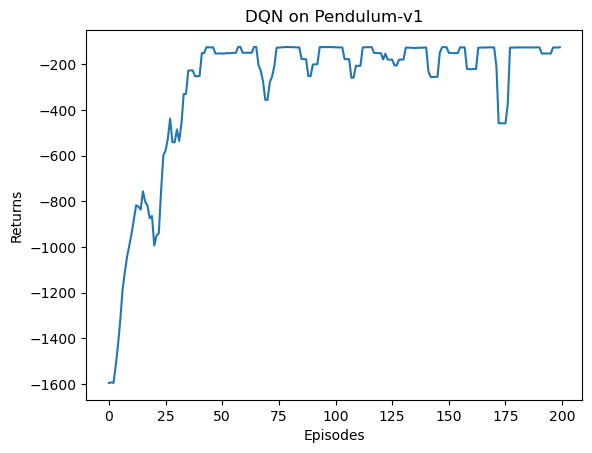

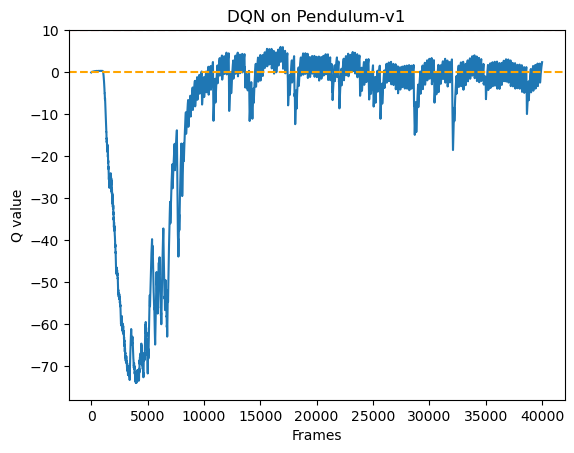

In [57]:
replay_buffer = ReplayBuffer(buffer_size) # 经验回放池
agent = DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, DQN_type='DQN') # 普通DQN智能体
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size) # 训练智能体

'''图表展示'''
episode_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episode_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list))) # 记录每一步的最大Q值
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, color='orange', linestyle='--')
plt.axhline(10, color='red', linestyle='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s, episode=200, return=-126.315]


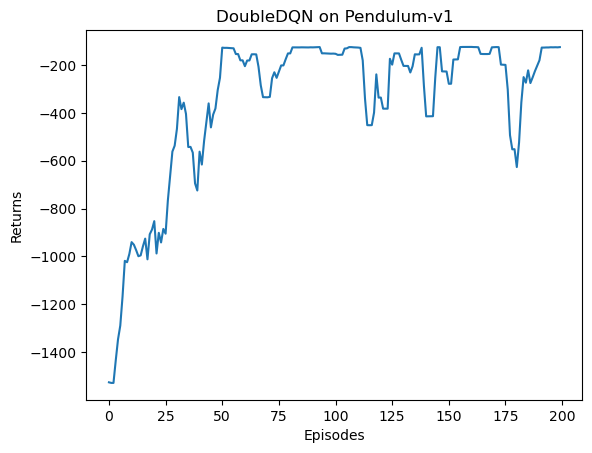

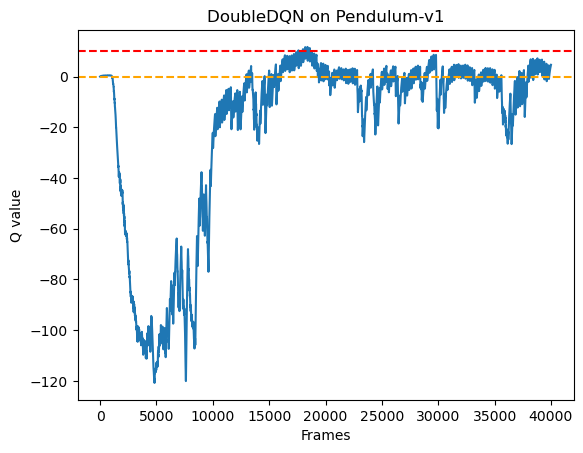

In [60]:
replay_buffer = ReplayBuffer(buffer_size) # 经验回放池
agent = DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, DQN_type='DoubleDQN') # Double DQN智能体
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size) # 训练智能体

'''图表展示'''
episode_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episode_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DoubleDQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list))) # 记录每一步的最大Q值
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, color='orange', linestyle='--')
plt.axhline(10, color='red', linestyle='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DoubleDQN on {}'.format(env_name))
plt.show()